# B5W1: Predicting Price Moves with News Sentiment

### Name: Tadele Bizuye

### Task 1: Exploratory Data Analysis (EDA)

In [12]:
# Task 1: Exploratory Data Analysis (EDA) - News Sentiment & Trends

# Import Some Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import nltk
from wordcloud import WordCloud, STOPWORDS
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Set global display and plot settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load Dataset
df = pd.read_csv("C:/Users/TadeleBizuye/raw_analyst_ratings.csv")
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\TadeleBizuye\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [13]:
# Drop the unnamed index column
df.drop(columns=['Unnamed: 0'], inplace=True)

In [14]:
df.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


## Basic Info and Descriptive Statistics

In [15]:
# Check shape and null values
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nMissing Values:\n", df.isnull().sum())

# Datatype summary
df.info()

# Check column names
df.columns

Rows: 1407328, Columns: 5

Missing Values:
 headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 53.7+ MB


Index(['headline', 'url', 'publisher', 'date', 'stock'], dtype='object')

## Data Cleaning & Formatting

In [16]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop any rows with missing essential values
df.dropna(subset=['headline', 'date', 'stock'], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Add headline length column
df['headline_length'] = df['headline'].apply(lambda x: len(str(x)))


##  Descriptive Statistics

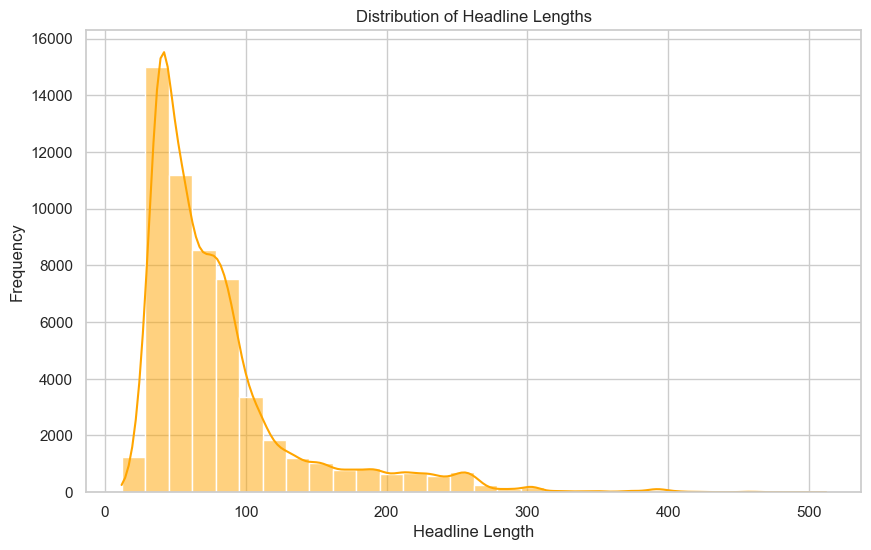

C:\Users\TadeleBizuye\AppData\Local\Temp\ipykernel_2648\1577425040.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_publishers.index, x=top_publishers.values, palette="viridis")


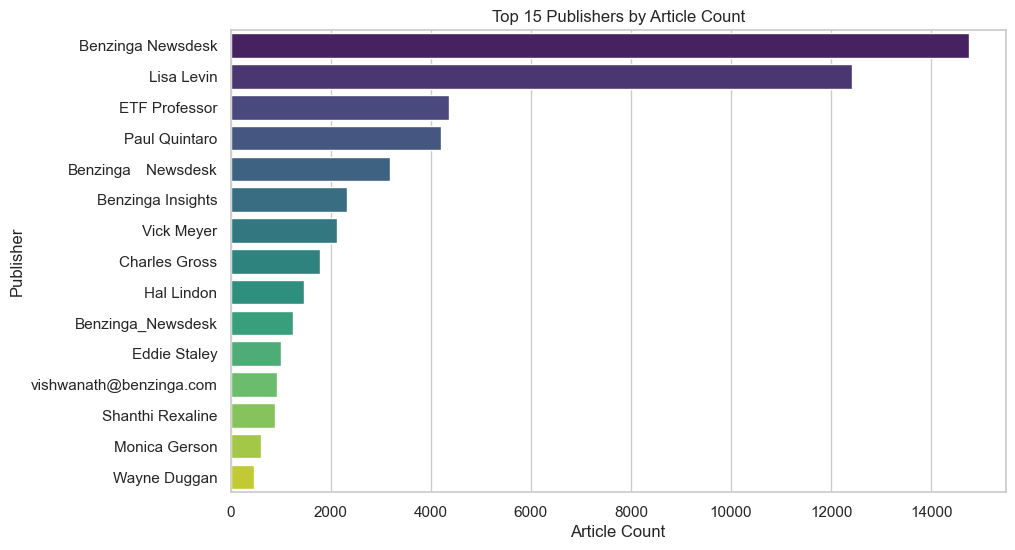

In [17]:
# Headline length distribution
sns.histplot(df['headline_length'], bins=30, kde=True, color='orange')
plt.title("Distribution of Headline Lengths")
plt.xlabel("Headline Length")
plt.ylabel("Frequency")
plt.show()

# Article count per publisher
top_publishers = df['publisher'].value_counts().head(15)
sns.barplot(y=top_publishers.index, x=top_publishers.values, palette="viridis")
plt.title("Top 15 Publishers by Article Count")
plt.xlabel("Article Count")
plt.ylabel("Publisher")
plt.show()


## Time Series Analysis

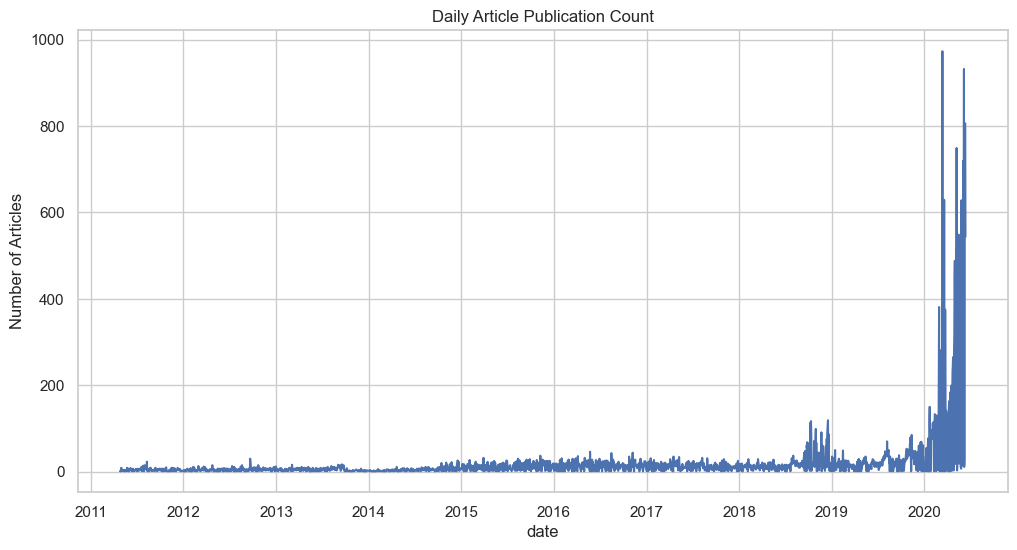

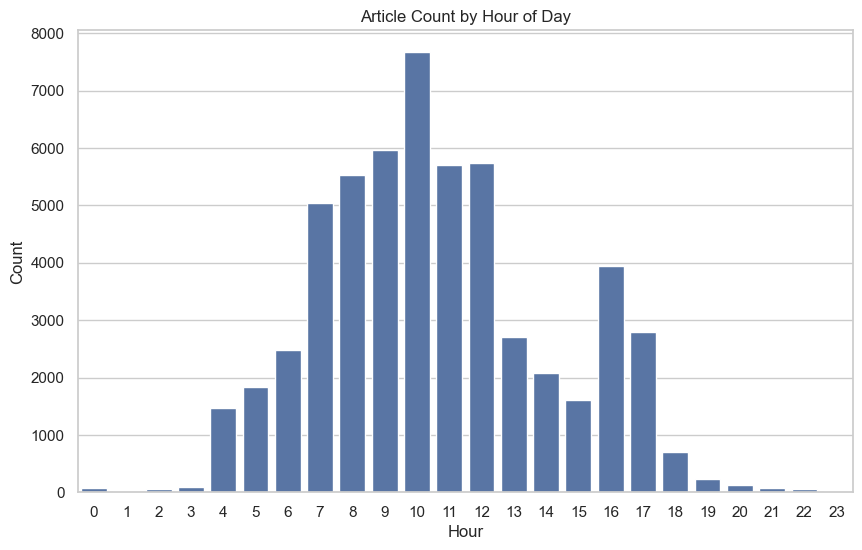

In [18]:
# Daily article counts
daily_counts = df.groupby(df['date'].dt.date).size()
daily_counts.plot(figsize=(12, 6), title="Daily Article Publication Count")
plt.ylabel("Number of Articles")
plt.show()

# Publishing time trends (hour of day, if available)
if df['date'].dt.hour.isnull().sum() == 0:
    df['hour'] = df['date'].dt.hour
    sns.countplot(x='hour', data=df)
    plt.title("Article Count by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Count")
    plt.show()


## NLP: Keyword Extraction & WordCloud

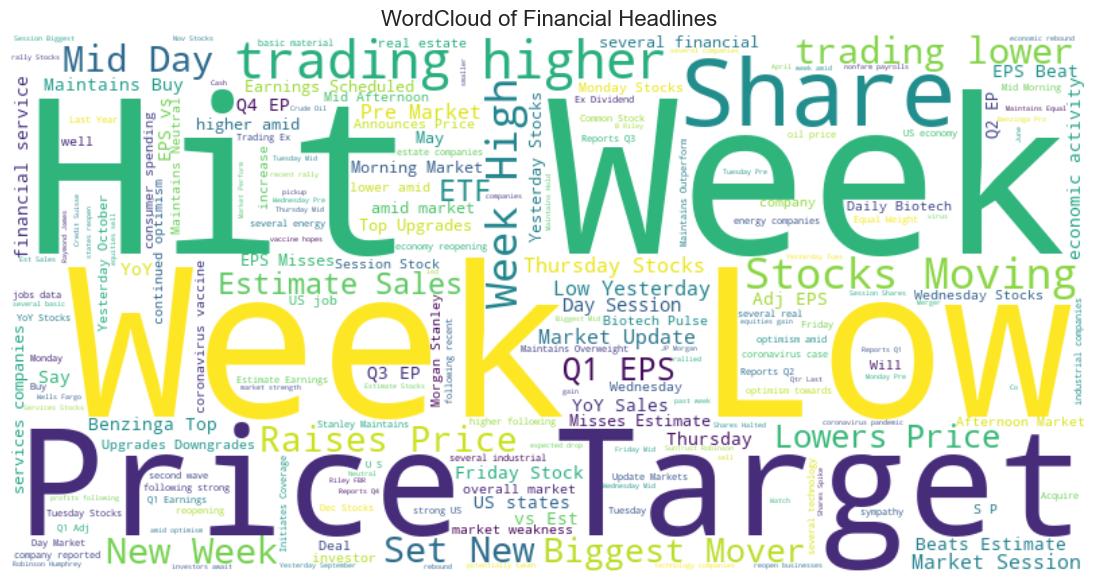

In [19]:
# Combine all headlines
text = ' '.join(df['headline'].dropna().astype(str))

# WordCloud
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Financial Headlines", fontsize=16)
plt.show()


## Sentiment Analysis (using VADER)

C:\Users\TadeleBizuye\AppData\Local\Temp\ipykernel_2648\788805458.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm')


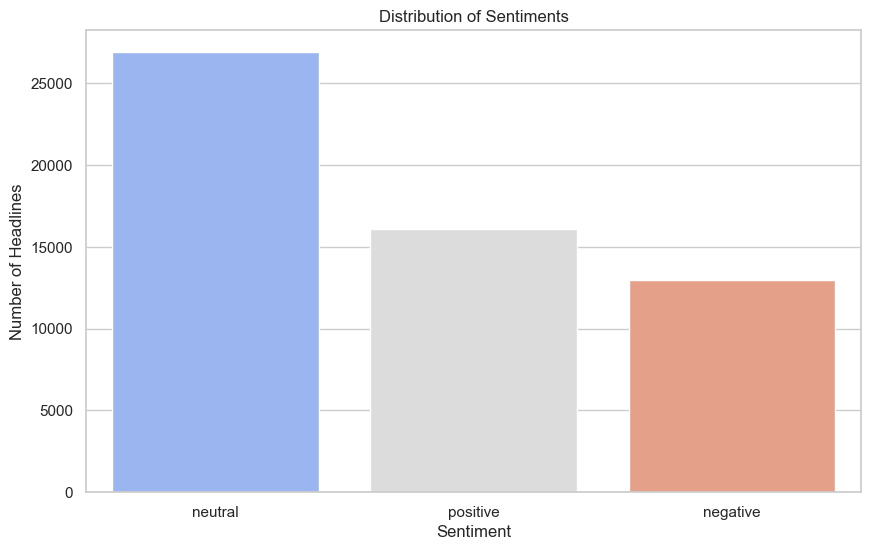

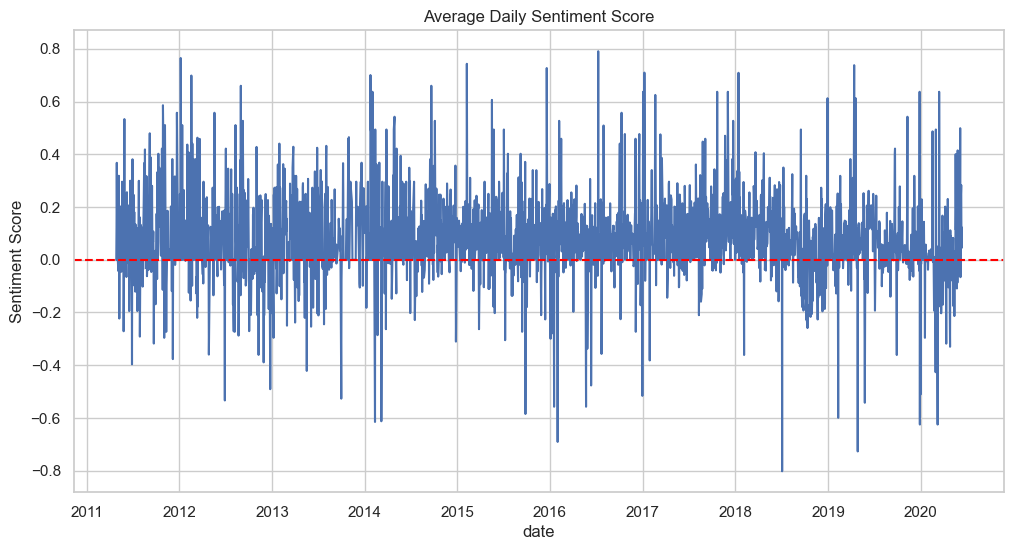

In [20]:
# Apply sentiment score
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Sentiment label
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))

# Sentiment Distribution
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Headlines")
plt.show()

# Average sentiment over time
daily_sentiment = df.groupby(df['date'].dt.date)['sentiment_score'].mean()
daily_sentiment.plot(figsize=(12, 6), title="Average Daily Sentiment Score")
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Sentiment Score")
plt.show()


## Save Cleaned Data for Next Task

In [21]:
df.to_csv("C:/Users/TadeleBizuye/cleaned_news_sentiment.csv", index=False)